# Gaussian Process Kinematics

### Importing Required Libraries

In [15]:
import functools
from typing import Any, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

We will start from a pre-generated dataset for this lab. This data comes from a simple
kinematics simulation that follows these equations:

$$
X_t = t \cdot \sin\left(\frac{2\pi t}{P}\right) + W_t
$$

where $T$ is a parameter of our system and $W_t$ is white noise with

$$
W_t \sim \mathcal{N}(0, \sigma_w^2)
$$

This equation is the product of a periodic function and a linear function, so it will be
interesting to see how different kernel assumptions for our Gaussian Process adapt to
the data. Our goal is to infer the true trajectory of the object from the noisy data.

We will generate a dataset where $P = 0.2$ and $\sigma_w = 0.5$.

In [16]:
# Let's generate the kinematics dataset.
x = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
f_true = 0.5 * np.squeeze(x * np.sin(x / 0.2))

rng = np.random.seed(2)
obs_indices = np.random.choice(np.arange(f_true.size), size=10, replace=False)
x_obs, f_obs = x[obs_indices], f_true[obs_indices]
y_obs = f_obs + np.random.normal(loc=0.0, scale=0.5, size=f_obs.shape)

### Part I: Implementing the Base Gaussian Process Class

To compare different kernels you will need to implement a GP class that:

1. Implement the calculation of the K matrix.
2. Store the data and the inverse K matrix for prediction.
3. Implement the mean and covariance prediction functions.
4. Implement calculation of likelihood of observations given kernel parameters.

We will assume that

$$
\mu(t) = 0
$$

for our GP.

In [17]:
class GaussianProcess:
    """Class that implements a Gaussian Process.

    Args:
        kernel_function: Function for calculating kappa(x,x').
    """
    def __init__(self, kernel_function: Any):
        """Initialize our class."""
        # Save the vectorized kernel function. Your kernel function
        # will take as input two scalar, but the vectorized function needs
        # to take in two arrays, one of length $m$ and one of length $n$,
        # and return a mxn matrix. We use one call of numpy.vectorize and take
        # advantage of the signature options.
        self._kernel_function = (
            np.vectorize(kernel_function,
                         signature='(),(m)->()'
                        )
        )

        # Initialize to None so we know to predict the prior to start.
        self.k_matrix_inv = None
        self.observed_x = None
        self.observed_y = None

    def calc_k_matrix(self, x_rows: np.ndarray, x_cols: np.ndarray) -> np.ndarray:
        """Calculate the K matrix at the given positions.

        Args:
            x_rows: X-position for the rows.
            x_cols: X-position for the columns.

        Returns:
            K(x_rows,x_cols) matrix.
        """
        #  All this function needs to do is call our vectorized kernel function
        kernel_scalar = self._kernel_function.pyfunc  # original scalar kernel

        n_rows, n_cols = x_rows.shape[0], x_cols.shape[0]
        k_matrix = np.zeros((n_rows, n_cols))

        for i in range(n_rows):
            for j in range(n_cols):
                # x_rows and x_cols are (n, 1), so index the scalar entry
                k_matrix[i, j] = kernel_scalar(x_rows[i, 0], x_cols[j, 0])
                
        return k_matrix

    def set_observations(self, observed_x: np.ndarray, observed_y: np.ndarray,
                         sigma_w: float):
        """Store the x and y that have been observed.

        Args:
            observed_x: Observed input points x.
            observed_y: Observed (noisy) outputs y.
            sigma_w: Observational noise standard deviation.

        Notes:
            Modifies internal variables.
        """
        # Save the observations.
        self.observed_x = observed_x
        self.observed_y = observed_y

        k_matrix = self.calc_k_matrix(observed_x, observed_x)

        # Save the K matrix inverse with the noise included.
        self.k_matrix_inv = np.linalg.inv(k_matrix + sigma_w ** 2 * np.eye(len(observed_x)))

    def predict(self, predict_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Predict the mean and covariance at given points.

        Args:
            predict_x: X-positions at which to make predictions.

        Returns:
            Mean and covariance matrix at the requested points.

        Notes:
            If no observations have been set, this will return the prior.
        """
        # Calculate the k_star_star matrix.
        k_star_star_matrix = self.calc_k_matrix(predict_x, predict_x)

        # Start with the prior predictions
        mean_pred = np.zeros(len(predict_x))
        cov_pred = k_star_star_matrix.copy()

        # Correct for observed data if it exists.
        if self.observed_x is not None:
            # Calculate the k_star matrix. Use the saved k_matrix_inv for speed
            # of computation.
            k_star_matrix = self.calc_k_matrix(self.observed_x, predict_x)

            # Update mean and covariance prediction.
            mean_pred += k_star_matrix.T @ self.k_matrix_inv @ self.observed_y
            cov_pred -=  k_star_matrix.T @ self.k_matrix_inv @ k_star_matrix

        return mean_pred, cov_pred

    def sample_f(self, predict_x: np.ndarray, n_samples: Optional[int] = 1) -> np.ndarray:
        """Return samples of the function space at the desired points.

        Args:
            predict_x: X-positions at which to make predictions.
            n_samples: Number of function samples to draw.

        Returns:
            Samples of the function space outputs.
        """
        # Get the mean and covariance prediction from our function.
        mean_pred, cov_pred = self.predict(predict_x)

        # Draw samples.
        f_samples = np.zeros((n_samples, len(predict_x)))
        for i in range(len(f_samples)):
            f_samples[i] = multivariate_normal.rvs(mean=mean_pred, cov=cov_pred)

        return f_samples

    def log_likelihood(self) -> float:
        """Return the log likelihood of the data for the given kernel.

        Returns:
            Log likelihood of the data.
        """
        # Implement the log likelihood of the data.
        if self.observed_x is None:
            raise ValueError("No observations have been set.")

        y = self.observed_y
        n = len(y)

        # We already stored (K_y)^{-1} in self.k_matrix_inv when set_observations was called.
        K_inv = self.k_matrix_inv
        K_y = np.linalg.inv(K_inv)

        sign, logdet = np.linalg.slogdet(K_y)
        quad_form = y.T @ (K_inv @ y)

        log_likelihood_calc = -0.5 * (quad_form + logdet + n * np.log(2 * np.pi))
        return log_likelihood_calc

Let’s test our implementation:

In [18]:
# A few tests for our GP functions.
def test_kernel_function(x, x_prime):
    return np.exp(-np.sum(np.square(x - x_prime))/20)

gp_test = GaussianProcess(test_kernel_function)

x_test = np.linspace(0,10,4).reshape(-1, 1)

# Test the K matrix calculation.
k_matrix = gp_test.calc_k_matrix(x_test, x_test)
np.testing.assert_array_almost_equal(
    k_matrix,
    [[1.0, 0.573753, 0.108368, 0.006738],
     [0.573753, 1.0, 0.573753, 0.108368],
     [0.108368, 0.573753, 1.0, 0.573753],
     [0.006738, 0.108368, 0.573753, 1.0]]
)

# Test the predictions without observations.
mean_test, cov_test = gp_test.predict(x_test)
np.testing.assert_array_almost_equal(mean_test, np.zeros(4))
np.testing.assert_array_almost_equal(
    cov_test,
    [[1.0, 0.573753, 0.108368, 0.006738],
     [0.573753, 1.0, 0.573753, 0.108368],
     [0.108368, 0.573753, 1.0, 0.573753],
     [0.006738, 0.108368, 0.573753, 1.0]]
)

# Test the predictions with observations
x_obs_test = np.linspace(0,10,4).reshape(-1, 1)
y_obs_test = np.linspace(5,50,4)
gp_test.set_observations(x_obs_test, y_obs_test, sigma_w=0.3)
mean_test, cov_test = gp_test.predict(x_test)
np.testing.assert_array_almost_equal(
    mean_test,
    np.array([5.346965, 18.628744, 34.861521, 46.078638])
)
np.testing.assert_array_almost_equal(
    cov_test,
    [[ 0.078941,  0.007533, -0.003469,  0.001145],
     [ 0.007533,  0.073929,  0.009536, -0.003469],
     [-0.003469,  0.009536,  0.073929,  0.007533],
     [ 0.001145, -0.003469,  0.007533,  0.078941]]
)

# Test the log likelihood calculation.
np.testing.assert_almost_equal(
    gp_test.log_likelihood(),
    -1262.211359395657
)

### Part II: Comparing Kernels for our GP.

Let’s compare how our different kernels impact our predictions. We can also test how different
kernel values are favored by the model. We will:

1. Compare the prediction of a squared exponential and a cosine kernel.
2. See how different choices of the period for our cosine kernel impact the likelihood of the
   observed data.

The squared exponential kernel is given by:

$$
\kappa(x, x') = A \cdot \exp\left( -\frac{(x - x')^2}{2l^2} \right)
$$

The cosine kernel is given by:

$$
\kappa(x, x') = A \cdot \cos\left( \frac{|x - x'|}{P} \right)
$$

In [19]:
# First we need to implement our two kernels.
def cosine_kernel(x: float, x_prime: float, period: float, amplitude: float) -> float:
    """Cosine kernel function.

    Args:
        x: First x-position at which to calculate the kernel.
        x_prime: Second x-position at which to calculate the kernel.
        period: Period of the cosine kernel.
        amplitude: Amplitude of the cosine kernel.

    Returns:
        Kernel function value.
    """
    # Implement cosine kernel function.
    return amplitude * np.cos(np.abs(x - x_prime) / period)

def squared_exp_kernel(x: float, x_prime: float, length_scale: float, amplitude: float) -> float:
    """Cosine kernel function.

    Args:
        x: First x-position at which to calculate the kernel.
        x_prime: Second x-position at which to calculate the kernel.
        length_scale: Length scale of the squared exponential kernel.
        amplitude: Amplitude of the squared exponential kernel.

    Returns:
        Kernel function value.
    """
    # Implement cosine kernel function.
    return amplitude * np.exp(-np.square(x - x_prime) / (2 * length_scale ** 2))

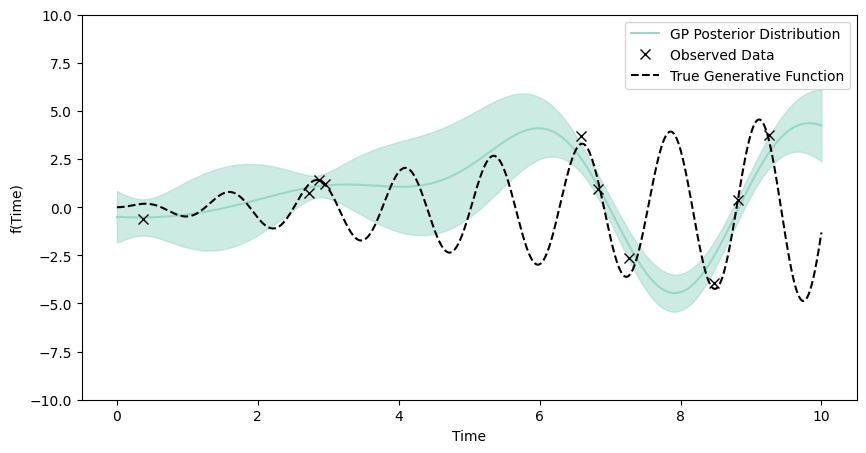

In [20]:
# First let's visualize the squared exponential kernel.
plt.figure(figsize=(10,5))

# Use functools.partial to set our kernel.
length_scale = 1.0
amplitude = 2.0
kernel_function = functools.partial(squared_exp_kernel, length_scale=length_scale, amplitude=amplitude)
gp = GaussianProcess(kernel_function)
sigma_w = 0.5

gp.set_observations(x_obs, y_obs, sigma_w)
y_pred_mean, y_pred_cov = gp.predict(x)
y_pred_std = np.sqrt(np.diag(y_pred_cov))
plt.plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
plt.plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
plt.plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
plt.fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std,
                 color = '#99d8c9', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('f(Time)')
plt.ylim([-10,10])
plt.show()

**Question:** Why are these predictions doing poorly? Limit your answer to the form of the kernel and not the specific parameters values.

- The predictions are bad because the squared-exponential kernel is the wrong shape for this data. That kernel assumes the function is smooth and slowly varying, and also that correlation between two points only decays with distance (nearby times look similar, far-away times look unrelated). Our true function is periodic with a growing amplitude (a sine wave whose peaks get larger over time). With an SE kernel, the GP can smooth through the noisy points, but it cannot “know” that the pattern should repeat or that oscillations should get bigger, so it produces a slowly varying, almost linear curve instead of strong up-and-down wiggles. In short: the kernel encodes “single smooth bump” behaviour, while the data come from a periodic, amplitude-changing process, so the model is misspecified and the fit looks poor.

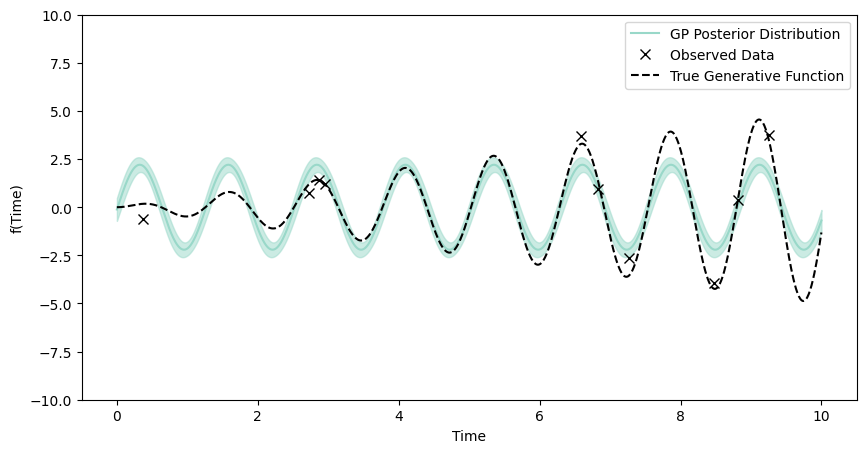

In [21]:
# Next let's visualize the cosine kernel.
plt.figure(figsize=(10,5))

# Use functools.partial to set our kernel.
period = 0.2
amplitude = 2.0
kernel_function = functools.partial(cosine_kernel, period=period, amplitude=amplitude)
gp = GaussianProcess(kernel_function)
sigma_w = 0.5

gp.set_observations(x_obs, y_obs, sigma_w)
y_pred_mean, y_pred_cov = gp.predict(x)
y_pred_std = np.sqrt(np.diag(y_pred_cov))
plt.plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
plt.plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
plt.plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
plt.fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std,
                 color = '#99d8c9', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('f(Time)')
plt.ylim([-10,10])
plt.show()

**Question:** How are these new predictions better than the previous? Why are the predictions still limited? Limit your answer to the form of the kernel and not the specific parameters values.

- These predictions are better because the cosine kernel “knows” the function should repeat (captures the periodic structure of the data much more effectively than the squared exponential kernel): it builds in a sinusoidal pattern, so the GP now tracks the up-and-down oscillations and gets the phase of the waves roughly right, instead of just drawing one smooth bump like the SE kernel did. But they’re still limited because a pure cosine kernel assumes a perfectly periodic wave with fixed amplitude and frequency across all time. This fails to capture the non-stationary nature of the actual function, which has amplitude that increases over time. As a result, the GP using the cosine kernel underestimates the growing variability in the later part of the curve.

In [22]:
# What if we combine our two kernels together?
def combined_kernel(x: float, x_prime: float, period_cosine: float, amplitude_cosine: float,
                    length_scale: float, amplitude_se: float) -> float:
    """Sum of cosine and squared exponential kernel.

    Args:
        x: First x-position at which to calculate the kernel.
        x_prime: Second x-position at which to calculate the kernel.
        period_cosine: Period of the cosine kernel.
        amplitude_cosine: Amplitude of the cosine kernel.
        length_scale: Length scale of the squared exponential kernel.
        amplitude_se: Amplitude of the squared exponential kernel.

    Returns:
        Kernel function value.
    """
    # Implement the combination.
    return cosine_kernel(x, x_prime, period_cosine, amplitude_cosine) + squared_exp_kernel(x, x_prime, length_scale, amplitude_se)

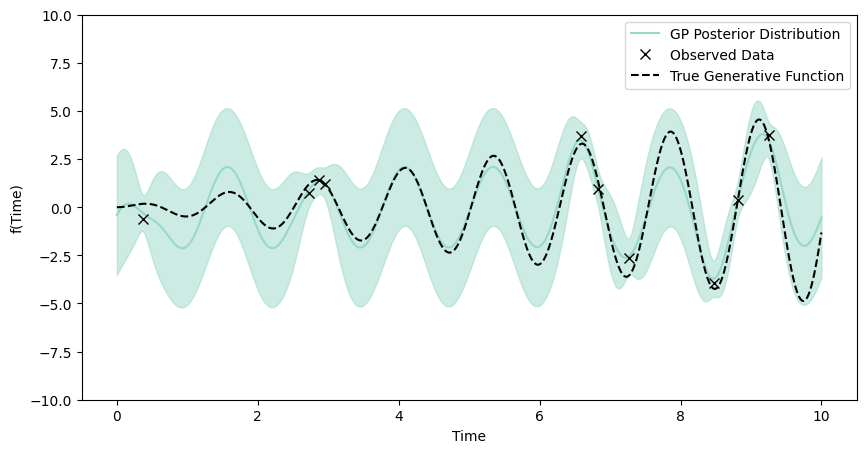

In [23]:
# Now let's visualize the combined kernel.
plt.figure(figsize=(10,5))

# Use functools.partial to set our kernel.
period_cosine = 0.2
amplitude_cosine = 2.0
length_scale = 0.2
amplitude_se = 2.0
kernel_function = functools.partial(
     combined_kernel,
     period_cosine=period_cosine,
     amplitude_cosine=amplitude_cosine,
     length_scale=length_scale,
     amplitude_se=amplitude_se
 )
gp = GaussianProcess(kernel_function)
sigma_w = 0.5

gp.set_observations(x_obs, y_obs, sigma_w)
y_pred_mean, y_pred_cov = gp.predict(x)
y_pred_std = np.sqrt(np.diag(y_pred_cov))
plt.plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
plt.plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
plt.plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
plt.fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std,
                 color = '#99d8c9', alpha=0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('f(Time)')
plt.ylim([-10,10])
plt.show()

**Question:** How are these new predictions better than the previous? Why might this be the case? Limit your answer to the form of the kernel and not the specific parameters values.

- These predictions are better because the combined kernel can express both “repeat” and “grow” at the same time. The cosine part tells the GP that the function should oscillate with a certain period. The squared-exponential part lets the GP slowly change the overall level, amplitude, and shape of the curve over time. By adding the two kernels, the GP can model a function that is periodic but not strictly stationary, allowing the oscillations to shift and stretch over time. This matches the true generative process much more closely than either kernel alone. The improvement happens purely because the sum kernel has richer expressiveness: it can capture multiple types of structure simultaneously, rather than forcing the whole function to look purely periodic or purely smooth.

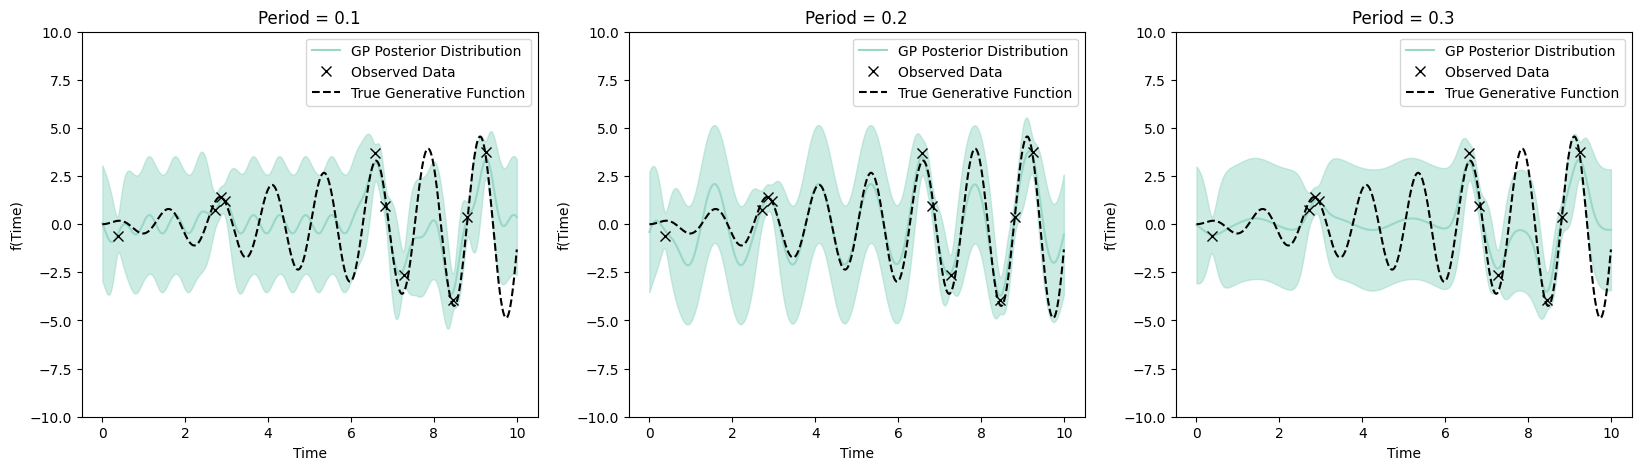

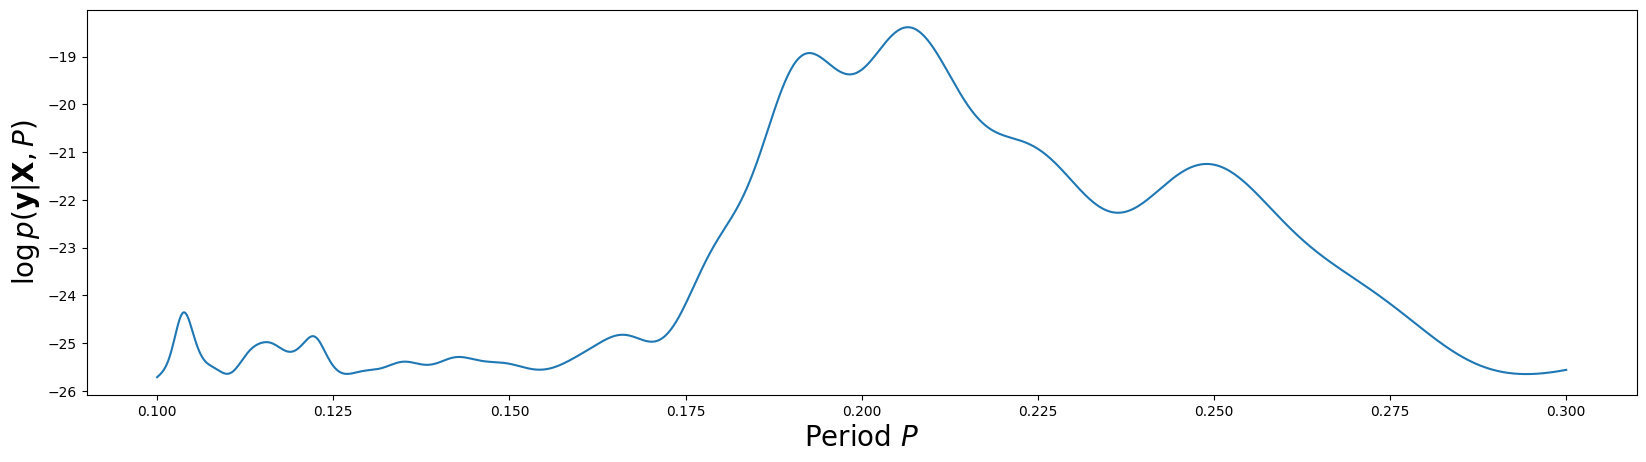

In [24]:
# We will compare the quality of different period choices.
periods = np.linspace(0.1,0.3,1000)
log_likelihoods = np.zeros(periods.shape)

# Let's start by plotting few length scales.
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=100)

for i, period in enumerate([0.1, 0.2, 0.3]):
    # Use the looped period parameter to initialize the kernel function.
    amplitude_cosine = 2.0
    length_scale = 0.2
    amplitude_se = 2.0
    kernel_function = functools.partial(
        combined_kernel,
        period_cosine=period,
        amplitude_cosine=amplitude_cosine,
        length_scale=length_scale,
        amplitude_se=amplitude_se
    )
    gp = GaussianProcess(kernel_function)
    gp.set_observations(x_obs, y_obs, sigma_w)
    y_pred_mean, y_pred_cov = gp.predict(x)
    y_pred_std = np.sqrt(np.diag(y_pred_cov))
    ax[i].plot(x, y_pred_mean, color = '#99d8c9', label = 'GP Posterior Distribution')
    ax[i].plot(x_obs, y_obs, 'x', color = 'k', label = 'Observed Data', markersize=7)
    ax[i].plot(x, f_true, '--', color = 'k', label = 'True Generative Function')
    ax[i].fill_between(x[:,0], y_pred_mean - 2 * y_pred_std, y_pred_mean + 2 * y_pred_std,
                       color = '#99d8c9', alpha=0.5)
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('f(Time)')
    ax[i].set_ylim([-10,10])
    ax[i].set_title(f'Period = {period}')

# plt.show()

# For each length scale, calculate the log likelihood.
for i, period in enumerate(periods):
    # Use the looped period parameter to initialize the kernel function.
    amplitude_cosine = 2.0
    length_scale = 0.2
    amplitude_se = 2.0
    kernel_function = functools.partial(
        combined_kernel,
        period_cosine=period,
        amplitude_cosine=amplitude_cosine,
        length_scale=length_scale,
        amplitude_se=amplitude_se
    )
    gp = GaussianProcess(kernel_function)
    gp.set_observations(x_obs, y_obs, sigma_w)
    log_likelihoods[i] = gp.log_likelihood()

plt.figure(figsize=(20,5))
plt.plot(periods, log_likelihoods)
# plt.axvline(0.2, c='k')
plt.xlabel(r'Period $P$', fontsize=20)
plt.ylabel(r'$\log p(\mathbf{y}|\mathbf{X},P)$', fontsize=20)

plt.show()

**Question:** What value of the period parameter maximizes the data likelihood? Does this make sense? How would you describe the predictions from p=0.1? Too complex or to too simple? Does this make sense?

- The log-likelihood plot clearly peaks around period = 0.2, which is the true period used in the generative function. This makes sense because the true data were generated with period P=0.2, so a kernel with the same period matches the repeating pattern best. So, the GP model correctly identifies the underlying periodic structure in the data when the kernel is tuned to the true frequency, leading to a better fit and higher likelihood.

- P=0.1: The kernel oscillates twice as fast as the data, so the GP tries to wiggle up and down too often. The predictions are too complex / over-fitted. They add extra waves that aren’t really in the underlying function, leading to overfitting and poor generalization, especially where data is sparse. So the likelihood is lower.

- P=0.3: The kernel oscillates too slowly, so the GP can’t reproduce all the ups and downs of the true signal. The predictions are too simple / under-fitted, missing several oscillations, which again leads to a lower likelihood.